https://www.kaggle.com/c/titanic
https://www.kaggle.com/alexisbcook/titanic-tutorial   
https://app.dataquest.io/m/289/introduction-to-numpy/7/selecting-columns-and-custom-slicing-ndarrays
https://neurohive.io/ru/osnovy-data-science/razbor-resheniya-zadachi-titanik-na-kaggle-dlya-nachinajushhih/
https://habr.com/ru/post/274171/
https://habr.com/ru/post/202090/
https://habr.com/ru/post/470535/ 

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot,show,hist
from scipy.stats.kde import gaussian_kde
from numpy import linspace,hstack
from pylab import plot,show,hist
#%config InlineBackend.figure_format = 'svg' для большей четкости графиков
matplotlib.style.use('ggplot')
%matplotlib inline


os.chdir(r'C:\Users\Mr Alex\Documents\GitHub\Kaggle\Titanic')
trd = pd.read_csv('train.csv')
tsd = pd.read_csv('test.csv')

#Сливаем открытые фреймы в один
td = pd.concat([trd, tsd], ignore_index=True, sort = False)

In [36]:
td.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
important = ['Survived', 'Sex', 'Age', 'Fare']

In [4]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
td.shape

(1309, 12)

In [6]:
td.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
#Статистика по колонкам с объектами
td.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [8]:
#Статистика по всем
td.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


In [9]:
#Только по цифровым колонкам ищем нужное нам значение
td.mean(numeric_only = True)

PassengerId    655.000000
Survived         0.383838
Pclass           2.294882
Age             29.881138
SibSp            0.498854
Parch            0.385027
Fare            33.295479
dtype: float64

Text(0.5, 1.0, 'Missing values heatmap')

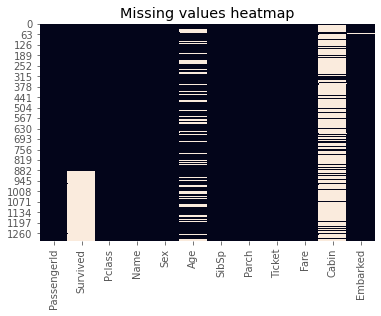

In [10]:
#Тепловая карта пропущенных значений
td.isnull().sum()
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")

In [11]:
#Статистика по родственникам на борту
td[['Parch', 'SibSp']].value_counts()

Parch  SibSp
0      0        790
       1        183
1      1         90
       0         52
2      0         43
       1         29
0      2         26
2      4         12
1      4         10
       2          9
       3          9
2      8          9
       3          8
       2          6
       5          6
3      1          5
4      1          4
5      1          4
0      3          3
6      1          2
3      0          2
4      0          2
5      0          2
9      1          2
3      2          1
dtype: int64

In [12]:
#Оцениваем возраст
td["Age"].unique()
td["Age"].mean()
td_age = td['Age'].value_counts()
age_24_30 = td_age.loc[[24.00, 30.00]]
td.loc[:10, ["Age", "Sex"]]

,Age,Sex
0,22.0,male
1,38.0,female
2,26.0,female
3,35.0,female
4,35.0,male
5,NaN,male
6,54.0,male
7,2.0,male
8,27.0,female
9,14.0,female


In [13]:
#Зависимая и независимые переменные. Сортировка выживших по полу и возрасту. 
td[["Survived", "Age", "Sex"]].value_counts().loc[1]

Age   Sex   
24.0  female    14
22.0  female    10
30.0  female     9
18.0  female     8
35.0  female     8
                ..
6.0   female     1
      male       1
7.0   female     1
8.0   female     1
      male       1
Length: 104, dtype: int64

In [14]:
#Зависимая и независимые переменные. Средняя доля выживших и среднее по возрасту и цене билета
td[["Survived", "Age", "Fare"]].mean(axis=0)

Survived     0.383838
Age         29.881138
Fare        33.295479
dtype: float64

In [15]:
#Получение сокращенного фрейма по конкретным критериям
td[td["Sex"].isin(['male'])].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [16]:
#Сортировка
td.sort_values('Age', ascending=False).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
630,631,1.0,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
987,988,NaN,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,76.0,1,0,19877,78.8500,C46,S
851,852,0.0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S
493,494,0.0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
96,97,0.0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C


In [17]:
#Агрегирование. Подсчет количества записей
td.groupby('Fare').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked
Fare,,,,,,,,,,,
0.0000,17,15,17,17,17,8,17,17,17,4,17
3.1708,1,0,1,1,1,1,1,1,1,0,1
4.0125,1,1,1,1,1,1,1,1,1,0,1
5.0000,1,1,1,1,1,1,1,1,1,1,1
6.2375,1,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
227.5250,5,4,5,5,5,4,5,5,5,3,5
247.5208,3,2,3,3,3,3,3,3,3,3,3
262.3750,7,2,7,7,7,7,7,7,7,6,7


<AxesSubplot:>

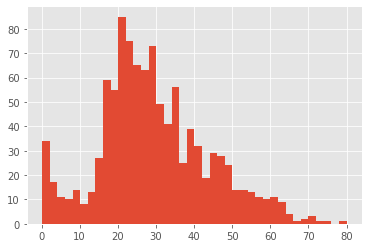

In [18]:
#Рисуем гистограмму
td['Age'].hist(bins=40)

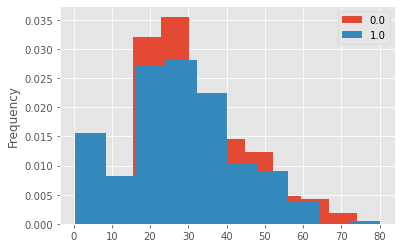

In [19]:
td.groupby('Survived')['Age'].plot.hist(density=True)
plt.legend()

In [20]:
for column in ['Survived', 'Pclass', 'Sex']:
    print(td[column].value_counts(normalize=True))

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64
3    0.541635
1    0.246753
2    0.211612
Name: Pclass, dtype: float64
male      0.644003
female    0.355997
Name: Sex, dtype: float64


In [21]:
# Нужно, чтобы подписи к картинкам отображались корректно по-русски
matplotlib.rc('font', family='Arial')

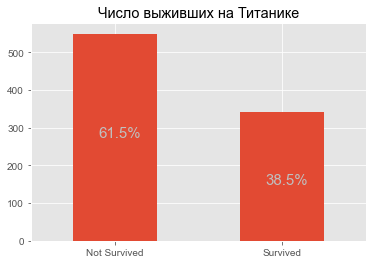

In [22]:
# Строим картинку
td['Survived'].value_counts().plot(kind='bar')
# Добавляем подпись
plt.title(u'Число выживших на Титанике')
plt.xticks([0, 1], ['Not Survived', 'Survived'], rotation=None)
plt.text(-0.1, 275, '61.5%', fontsize=15, color='silver')
plt.text(0.9, 150, '38.5%', fontsize=15, color='silver');

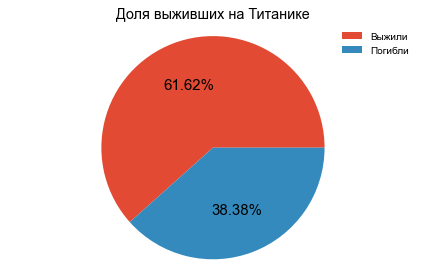

In [23]:
#Доля выживших на Титанике
fig, ax = plt.subplots(1)
td['Survived'].value_counts().plot(kind='pie', labels=['', ''],
                                   ax=ax, autopct='%.2f%%', fontsize=15)
ax.set_title(u'Доля выживших на Титанике')
ax.axis('equal')
ax.legend(labels=[u'Выжили', u'Погибли'], framealpha=0)
ax.set_ylabel('')
plt.tight_layout()

Text(0.5, 1.0, 'Распределение возраста')

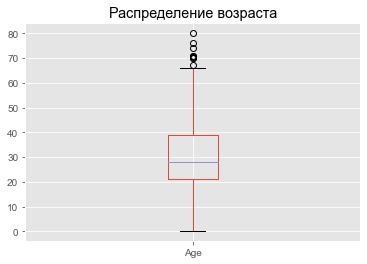

In [24]:
td['Age'].plot(kind='box')
plt.title(u'Распределение возраста')

Text(0.5, 0.98, '')

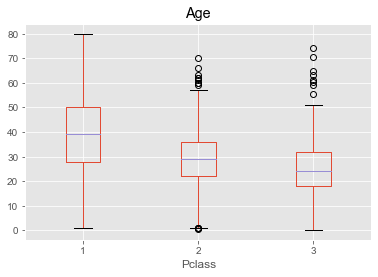

In [25]:
ax = td.boxplot(column='Age', by='Pclass')
# Хак для того, чтобы исправить наезжающие заголовки графика
ax.get_figure().suptitle('')

In [26]:
#иерархический кластерный анализ
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [27]:
td_new = td[important]

In [37]:
td_new.head()

,Survived,Sex,Age,Fare
0,0.0,male,22.0,7.2500
1,1.0,female,38.0,71.2833
2,1.0,female,26.0,7.9250
3,1.0,female,35.0,53.1000
4,0.0,male,35.0,8.0500
